# FluidityNonlocal Flow Curve: Shear Banding Detection

## Learning Objectives

1. Understand spatial diffusion via cooperativity length ξ in thixotropic fluids
2. Detect shear banding from fluidity profiles (CV > 0.3, f_max/f_min > 10)
3. Compare local vs non-local model predictions on emulsion flow curves
4. Fit 10-parameter nonlocal model using NLSQ → NUTS workflow
5. Quantify when non-local effects dominate vs local approximation suffices

## Model Overview

**FluidityNonlocal** extends the local fluidity model with spatial diffusion:

$$
\frac{\partial f}{\partial t} = \frac{f_{\text{loc}}(\sigma) - f}{\theta} + \xi^2 \frac{\partial^2 f}{\partial y^2}
$$

where:
- $f_{\text{loc}}(\sigma) = f_0 + (f_1 - f_0) \tanh\left(\frac{\sigma - \sigma_c}{\Delta\sigma}\right)$ (local steady-state solution)
- $\theta$ = structural relaxation time
- $\xi$ = cooperativity length (spatial diffusion scale)
- $y$ = gap coordinate (0 to $h$)

**Shear Banding Metrics:**
- Coefficient of variation: $\text{CV} = \sigma(f) / \mu(f) > 0.3$
- Fluidity contrast: $f_{\max} / f_{\min} > 10$

**Parameters (10):**
1. $f_0$ = low-stress fluidity (s⁻¹)
2. $f_1$ = high-stress fluidity (s⁻¹)
3. $\sigma_c$ = critical stress (Pa)
4. $\Delta\sigma$ = transition width (Pa)
5. $\theta$ = relaxation time (s)
6. $n$ = flow index
7. $\alpha$ = stress exponent
8. $K$ = consistency (Pa·sⁿ)
9. $\tau_y$ = yield stress (Pa)
10. $\xi$ = cooperativity length (m)

In [1]:
# Colab setup
try:
    import google.colab
    IN_COLAB = True
    !pip install -q rheojax nlsq numpyro arviz
except ImportError:
    IN_COLAB = False

# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# RheoJAX imports
from rheojax.core.jax_config import safe_import_jax
from rheojax.core.data import RheoData
from rheojax.models.fluidity import FluidityNonlocal, FluidityLocal
from rheojax.logging import configure_logging, get_logger
from rheojax.utils.metrics import compute_fit_quality

# JAX setup (NLSQ auto-configures float64)
jax, jnp = safe_import_jax()

# Logging
configure_logging(level="INFO")
logger = get_logger(__name__)

# Plotting defaults
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
})

logger.info("Setup complete", jax_version=jax.__version__)

In [2]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {'R2': r2, 'RMSE': rmse}

## Theory: Non-Local Effects and Shear Banding

### Spatial Diffusion PDE

The fluidity field $f(y, t)$ evolves according to:

$$
\frac{\partial f}{\partial t} = \underbrace{\frac{f_{\text{loc}}(\sigma) - f}{\theta}}_{\text{Local relaxation}} + \underbrace{\xi^2 \frac{\partial^2 f}{\partial y^2}}_{\text{Spatial diffusion}}
$$

**Cooperativity Length $\xi$:**
- Physical interpretation: length scale over which stress perturbations propagate
- Typical values: 1-100 μm for soft materials
- $\xi \ll h$: local approximation valid (FluidityLocal sufficient)
- $\xi \sim h$: non-local effects important (shear banding possible)

### Shear Banding Criterion

Steady-state fluidity profile $f(y)$ indicates banding when:

1. **High spatial variation:**
   $$\text{CV} = \frac{\sigma_f}{\mu_f} > 0.3$$
   where $\sigma_f = \sqrt{\langle (f - \langle f \rangle)^2 \rangle}$

2. **Strong contrast:**
   $$\frac{f_{\max}}{f_{\min}} > 10$$

3. **Bimodal distribution:**
   - Low-fluidity band: $f \approx f_0$ (nearly solid)
   - High-fluidity band: $f \approx f_1$ (flowing)

### Constitutive Relation

Stress-fluidity coupling:

$$
\sigma = \tau_y + K \dot{\gamma}^n, \quad \dot{\gamma} = f \cdot \sigma^\alpha
$$

**Key Difference from Local Model:**
- Local: $f$ uniform across gap → single shear rate
- Nonlocal: $f(y)$ profile → shear rate banding $\dot{\gamma}(y)$

## Data: Emulsion Flow Curve

Synthetic emulsion data showing characteristic stress plateau (yield region).

<>:35: SyntaxWarning: invalid escape sequence '\d'
<>:36: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\d'
<>:36: SyntaxWarning: invalid escape sequence '\s'
/var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/ipykernel_44377/1375425042.py:35: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xlabel('Shear Rate $\dot{\gamma}$ (s$^{-1}$)')
/var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/ipykernel_44377/1375425042.py:36: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Stress $\sigma$ (Pa)')


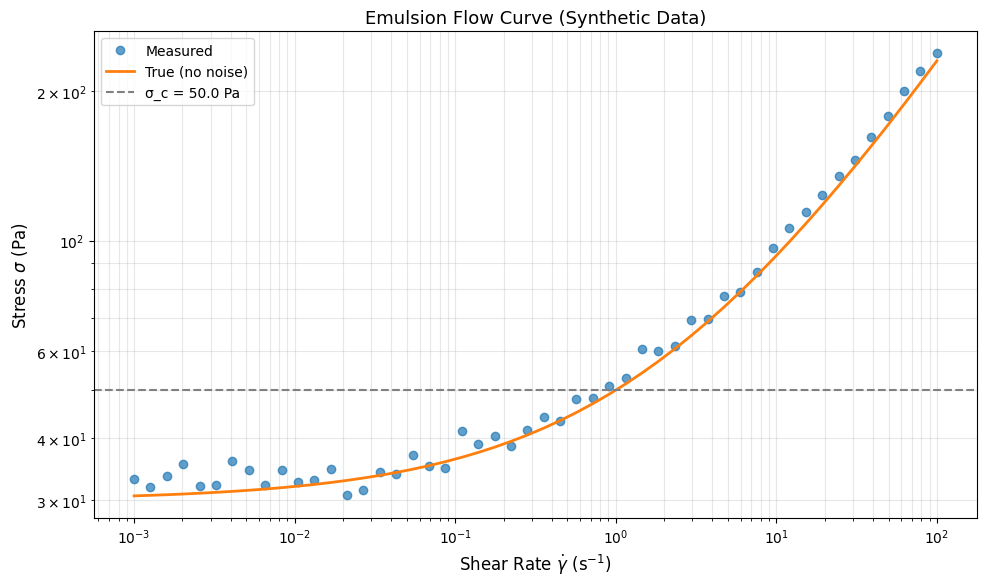

In [3]:
# Generate synthetic emulsion flow curve data
np.random.seed(42)

# Shear rate range spanning yield transition
gamma_dot = np.logspace(-3, 2, 50)  # 0.001 to 100 s^-1

# Ground truth parameters (moderate shear banding)
f0_true = 0.01      # Low fluidity (s^-1)
f1_true = 1.0       # High fluidity (s^-1)
sigma_c_true = 50.0 # Critical stress (Pa)
delta_sigma_true = 10.0  # Transition width (Pa)
theta_true = 5.0    # Relaxation time (s)
n_true = 0.5        # Shear-thinning
alpha_true = 1.0    # Linear stress dependence
K_true = 20.0       # Consistency (Pa·s^n)
tau_y_true = 30.0   # Yield stress (Pa)
xi_true = 5e-5      # 50 μm cooperativity length

# Simple Herschel-Bulkley flow curve for synthetic data
# sigma = tau_y + K * gamma_dot^n
sigma_true = tau_y_true + K_true * gamma_dot**n_true

# Add measurement noise (5% relative + 2 Pa absolute)
noise = 0.05 * sigma_true + 2.0 * np.random.randn(len(sigma_true))
sigma = sigma_true + noise

# Ensure positive stresses
sigma = np.maximum(sigma, 1.0)

# Visualization
fig, ax = plt.subplots()
ax.loglog(gamma_dot, sigma, 'o', label='Measured', alpha=0.7)
ax.loglog(gamma_dot, sigma_true, '-', label='True (no noise)', linewidth=2)
ax.axhline(sigma_c_true, color='gray', linestyle='--', label=f'σ_c = {sigma_c_true} Pa')
ax.set_xlabel('Shear Rate $\dot{\gamma}$ (s$^{-1}$)')
ax.set_ylabel('Stress $\sigma$ (Pa)')
ax.set_title('Emulsion Flow Curve (Synthetic Data)')
ax.legend()
ax.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()
plt.close('all')

logger.info("Data generated", n_points=len(gamma_dot), sigma_range=(sigma.min(), sigma.max()))

## Model Initialization

Configure **FluidityNonlocal** with spatial discretization:
- `N_y = 64`: number of grid points across gap
- `gap_width = 1e-3`: 1 mm gap (typical rheometer geometry)

In [4]:
# Create RheoData object
rheo_data = RheoData(
    x=gamma_dot,
    y=sigma,
    initial_test_mode='flow_curve',
    metadata={'material': 'emulsion', 'temperature': 25.0}
)

# Initialize nonlocal model
model_nonlocal = FluidityNonlocal(
    N_y=64,           # Spatial resolution
    gap_width=1e-3    # 1 mm gap
)

logger.info(
    "Model initialized",
    n_params=len(model_nonlocal.parameters),
    N_y=64,
    gap_width=1e-3
)

# Display parameter bounds
print("\nParameter Bounds:")
for name, param in model_nonlocal.parameters.items():
    print(f"  {name:12s}: [{param.bounds[0]:8.2e}, {param.bounds[1]:8.2e}]")


Parameter Bounds:
  G           : [1.00e+03, 1.00e+09]
  tau_y       : [1.00e+01, 1.00e+06]
  K           : [1.00e+00, 1.00e+06]
  n_flow      : [1.00e-01, 2.00e+00]
  f_eq        : [1.00e-12, 1.00e-03]
  f_inf       : [1.00e-06, 1.00e+00]
  theta       : [1.00e-01, 1.00e+04]
  a           : [0.00e+00, 1.00e+02]
  n_rejuv     : [0.00e+00, 2.00e+00]
  xi          : [1.00e-09, 1.00e-03]


## NLSQ Fitting

Non-linear least squares optimization using NLSQ 0.6.6+ workflow system.

19:49:40 | INFO     | rheojax.models.fluidity.nonlocal_model | model_fit started | operation=model_fit | phase=start | model=FluidityNonlocal | test_mode=unknown | data_shape=(50,)


19:49:40 | INFO     | rheojax.utils.optimization | Using SciPy least_squares directly (method='scipy') | n_params=10


19:49:40 | INFO     | rheojax.models.fluidity.nonlocal_model | model_fit completed | operation=model_fit | phase=end | elapsed_seconds=0.2122 | status=success | model=FluidityNonlocal | test_mode=flow_curve | data_shape=(50,) | N_y=64


19:49:40 | INFO     | rheojax.core.base | Fit completed | model=FluidityNonlocal | fitted=True | R2=-327.2350 | data_shape=(50,)



NLSQ Fitted Parameters:
  G           : 1.0000e+06
  tau_y       : 1.4950e+01
  K           : 4.4540e+02
  n_flow      : 4.1947e-01
  f_eq        : 1.0000e-06
  f_inf       : 1.0000e-03
  theta       : 1.0000e+01
  a           : 1.0000e+00
  n_rejuv     : 1.0000e+00
  xi          : 1.0000e-05

R² = -327.235013
RMSE = 953.1024 Pa


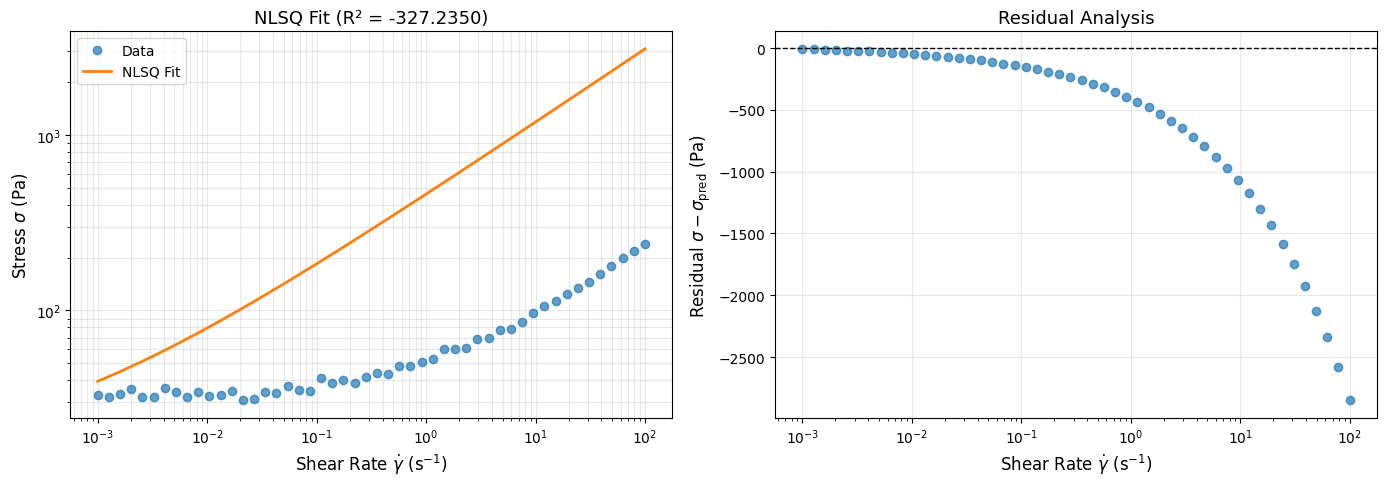

In [5]:
# NLSQ fit (warm-start for Bayesian inference)
model_nonlocal.fit(gamma_dot, sigma, test_mode='flow_curve', method='scipy')

# Extract fitted parameters
params_nlsq = {
    name: model_nonlocal.parameters[name].value
    for name in model_nonlocal.parameters.keys()
}

print("\nNLSQ Fitted Parameters:")
for name, value in params_nlsq.items():
    print(f"  {name:12s}: {value:10.4e}")

# Predictions
sigma_pred_nlsq = model_nonlocal.predict(gamma_dot, test_mode='flow_curve')

# Compute fit quality
metrics = compute_fit_quality(sigma, np.array(sigma_pred_nlsq).flatten())
r_squared = metrics['R2']
rmse = metrics['RMSE']

print(f"\nR² = {r_squared:.6f}")
print(f"RMSE = {rmse:.4f} Pa")

# Plot fit quality
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Flow curve
ax1.loglog(gamma_dot, sigma, 'o', label='Data', alpha=0.7)
ax1.loglog(gamma_dot, sigma_pred_nlsq, '-', label='NLSQ Fit', linewidth=2)
ax1.set_xlabel(r'Shear Rate $\dot{\gamma}$ (s$^{-1}$)')
ax1.set_ylabel(r'Stress $\sigma$ (Pa)')
ax1.set_title(f'NLSQ Fit (R² = {r_squared:.4f})')
ax1.legend()
ax1.grid(True, which='both', alpha=0.3)

# Residuals
residuals = sigma - np.array(sigma_pred_nlsq).flatten()
ax2.semilogx(gamma_dot, residuals, 'o', alpha=0.7)
ax2.axhline(0, color='k', linestyle='--', linewidth=1)
ax2.set_xlabel(r'Shear Rate $\dot{\gamma}$ (s$^{-1}$)')
ax2.set_ylabel(r'Residual $\sigma - \sigma_{\mathrm{pred}}$ (Pa)')
ax2.set_title('Residual Analysis')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

logger.info("NLSQ fit complete", R2=r_squared, RMSE=rmse)

## Bayesian Inference with NUTS

Use NLSQ solution as warm-start for Hamiltonian Monte Carlo sampling.

In [6]:
# Bayesian inference (4 chains for production-ready diagnostics)
result_bayes = model_nonlocal.fit_bayesian(
    gamma_dot, sigma,
    test_mode='flow_curve',
    num_warmup=1000,
    num_samples=2000,
    num_chains=4,
    seed=42
)

# Extract posterior samples
posterior = result_bayes.posterior_samples

# Compute credible intervals (95%)
intervals = model_nonlocal.get_credible_intervals(posterior, credibility=0.95)

print("\nBayesian Parameter Estimates (95% HDI):")
print(f"{'Parameter':<12s} {'NLSQ':>12s} {'Median':>12s} {'Lower':>12s} {'Upper':>12s}")
print("-" * 60)
for name in model_nonlocal.parameters.keys():
    nlsq_val = params_nlsq[name]
    median = float(jnp.median(posterior[name]))
    lower, upper = intervals[name]
    print(f"{name:<12s} {nlsq_val:12.4e} {median:12.4e} {lower:12.4e} {upper:12.4e}")

logger.info("Bayesian inference complete", num_samples=2000, num_chains=4)

19:49:41 | INFO     | rheojax.core.bayesian | bayesian_inference started | operation=bayesian_inference | phase=start | model=FluidityNonlocal | num_warmup=1000 | num_samples=2000 | num_chains=4


19:49:41 | INFO     | rheojax.core.bayesian | Bayesian inference started | model=FluidityNonlocal | test_mode=flow_curve | num_warmup=1000 | num_samples=2000 | num_chains=4


  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:02<2:13:07,  2.66s/it]

warmup:   0%|          | 2/3000 [00:05<2:10:50,  2.62s/it]

warmup:   1%|▏         | 38/3000 [00:05<04:16, 11.56it/s] 

warmup:   2%|▏         | 55/3000 [00:05<03:04, 15.98it/s]

warmup:   2%|▏         | 67/3000 [00:06<02:47, 17.50it/s]

warmup:   3%|▎         | 76/3000 [00:06<02:42, 18.05it/s]

warmup:   3%|▎         | 83/3000 [00:07<02:33, 19.06it/s]

warmup:   3%|▎         | 88/3000 [00:07<02:31, 19.27it/s]

warmup:   3%|▎         | 92/3000 [00:07<02:28, 19.56it/s]

warmup:   3%|▎         | 96/3000 [00:07<02:24, 20.16it/s]

warmup:   3%|▎         | 100/3000 [00:07<02:21, 20.51it/s]

warmup:   4%|▎         | 105/3000 [00:07<02:02, 23.55it/s]

warmup:   4%|▍         | 114/3000 [00:08<01:26, 33.53it/s]

warmup:   4%|▍         | 124/3000 [00:08<01:04, 44.84it/s]

warmup:   4%|▍         | 134/3000 [00:08<00:51, 55.62it/s]

warmup:   5%|▍         | 143/3000 [00:08<00:46, 61.87it/s]

warmup:   5%|▌         | 156/3000 [00:08<00:36, 78.03it/s]

warmup:   6%|▌         | 166/3000 [00:08<00:42, 66.18it/s]

warmup:   6%|▌         | 181/3000 [00:08<00:33, 83.95it/s]

warmup:   7%|▋         | 198/3000 [00:08<00:27, 103.33it/s]

warmup:   7%|▋         | 220/3000 [00:09<00:20, 132.73it/s]

warmup:   8%|▊         | 247/3000 [00:09<00:16, 169.03it/s]

warmup:   9%|▉         | 266/3000 [00:09<00:15, 173.69it/s]

warmup:  10%|▉         | 285/3000 [00:09<00:17, 157.90it/s]

warmup:  10%|█         | 302/3000 [00:09<00:17, 154.46it/s]

warmup:  11%|█         | 326/3000 [00:09<00:15, 175.71it/s]

warmup:  12%|█▏        | 345/3000 [00:09<00:15, 168.78it/s]

warmup:  12%|█▏        | 366/3000 [00:09<00:14, 178.27it/s]

warmup:  13%|█▎        | 386/3000 [00:09<00:14, 184.19it/s]

warmup:  14%|█▎        | 412/3000 [00:10<00:12, 202.69it/s]

warmup:  14%|█▍        | 433/3000 [00:10<00:16, 159.64it/s]

warmup:  15%|█▌        | 453/3000 [00:10<00:15, 168.88it/s]

warmup:  16%|█▌        | 472/3000 [00:10<00:15, 161.38it/s]

warmup:  16%|█▋        | 495/3000 [00:10<00:14, 178.62it/s]

warmup:  17%|█▋        | 519/3000 [00:10<00:12, 194.53it/s]

warmup:  18%|█▊        | 546/3000 [00:10<00:11, 214.14it/s]

warmup:  19%|█▉        | 570/3000 [00:10<00:11, 220.03it/s]

warmup:  20%|█▉        | 595/3000 [00:10<00:10, 228.35it/s]

warmup:  21%|██        | 619/3000 [00:11<00:10, 225.57it/s]

warmup:  21%|██▏       | 642/3000 [00:11<00:11, 212.54it/s]

warmup:  22%|██▏       | 670/3000 [00:11<00:10, 231.24it/s]

warmup:  23%|██▎       | 694/3000 [00:11<00:09, 231.62it/s]

warmup:  24%|██▍       | 718/3000 [00:11<00:09, 230.13it/s]

warmup:  25%|██▍       | 744/3000 [00:11<00:09, 235.81it/s]

warmup:  26%|██▌       | 768/3000 [00:11<00:09, 227.44it/s]

warmup:  27%|██▋       | 796/3000 [00:11<00:09, 239.26it/s]

warmup:  27%|██▋       | 821/3000 [00:11<00:10, 216.68it/s]

warmup:  28%|██▊       | 848/3000 [00:12<00:09, 229.88it/s]

warmup:  29%|██▉       | 878/3000 [00:12<00:08, 248.99it/s]

warmup:  30%|███       | 905/3000 [00:12<00:08, 254.54it/s]

warmup:  31%|███       | 932/3000 [00:12<00:08, 256.51it/s]

warmup:  32%|███▏      | 958/3000 [00:12<00:08, 243.09it/s]

warmup:  33%|███▎      | 983/3000 [00:12<00:09, 218.86it/s]

sample:  34%|███▎      | 1006/3000 [00:12<00:09, 218.71it/s]

sample:  34%|███▍      | 1029/3000 [00:12<00:10, 187.53it/s]

sample:  35%|███▌      | 1053/3000 [00:13<00:09, 200.02it/s]

sample:  36%|███▌      | 1082/3000 [00:13<00:08, 222.83it/s]

sample:  37%|███▋      | 1108/3000 [00:13<00:08, 232.19it/s]

sample:  38%|███▊      | 1133/3000 [00:13<00:07, 233.91it/s]

sample:  39%|███▊      | 1159/3000 [00:13<00:07, 237.40it/s]

sample:  39%|███▉      | 1184/3000 [00:13<00:07, 233.48it/s]

sample:  40%|████      | 1208/3000 [00:13<00:09, 195.89it/s]

sample:  41%|████      | 1236/3000 [00:13<00:08, 213.70it/s]

sample:  42%|████▏     | 1261/3000 [00:13<00:07, 221.89it/s]

sample:  43%|████▎     | 1290/3000 [00:14<00:07, 238.97it/s]

sample:  44%|████▍     | 1317/3000 [00:14<00:06, 247.20it/s]

sample:  45%|████▍     | 1343/3000 [00:14<00:06, 249.18it/s]

sample:  46%|████▌     | 1371/3000 [00:14<00:06, 255.99it/s]

sample:  47%|████▋     | 1397/3000 [00:14<00:07, 211.05it/s]

sample:  47%|████▋     | 1422/3000 [00:14<00:07, 218.93it/s]

sample:  48%|████▊     | 1446/3000 [00:14<00:07, 221.18it/s]

sample:  49%|████▉     | 1469/3000 [00:14<00:07, 216.27it/s]

sample:  50%|█████     | 1501/3000 [00:14<00:06, 242.49it/s]

sample:  51%|█████     | 1527/3000 [00:15<00:05, 246.55it/s]

sample:  52%|█████▏    | 1554/3000 [00:15<00:05, 251.95it/s]

sample:  53%|█████▎    | 1580/3000 [00:15<00:06, 235.90it/s]

sample:  54%|█████▎    | 1605/3000 [00:15<00:05, 234.85it/s]

sample:  54%|█████▍    | 1629/3000 [00:15<00:05, 231.98it/s]

sample:  55%|█████▌    | 1653/3000 [00:15<00:05, 229.52it/s]

sample:  56%|█████▌    | 1678/3000 [00:15<00:05, 234.82it/s]

sample:  57%|█████▋    | 1705/3000 [00:15<00:05, 244.32it/s]

sample:  58%|█████▊    | 1730/3000 [00:15<00:05, 236.84it/s]

sample:  58%|█████▊    | 1754/3000 [00:15<00:05, 237.56it/s]

sample:  59%|█████▉    | 1780/3000 [00:16<00:05, 241.22it/s]

sample:  60%|██████    | 1805/3000 [00:16<00:04, 242.59it/s]

sample:  61%|██████    | 1830/3000 [00:16<00:05, 204.73it/s]

sample:  62%|██████▏   | 1857/3000 [00:16<00:05, 220.13it/s]

sample:  63%|██████▎   | 1881/3000 [00:16<00:04, 224.15it/s]

sample:  64%|██████▎   | 1909/3000 [00:16<00:04, 239.17it/s]

sample:  65%|██████▍   | 1937/3000 [00:16<00:04, 249.46it/s]

sample:  65%|██████▌   | 1963/3000 [00:16<00:04, 251.17it/s]

sample:  66%|██████▋   | 1989/3000 [00:16<00:03, 252.75it/s]

sample:  67%|██████▋   | 2015/3000 [00:17<00:04, 208.15it/s]

sample:  68%|██████▊   | 2040/3000 [00:17<00:04, 215.95it/s]

sample:  69%|██████▉   | 2064/3000 [00:17<00:04, 221.58it/s]

sample:  70%|██████▉   | 2088/3000 [00:17<00:04, 220.89it/s]

sample:  70%|███████   | 2114/3000 [00:17<00:03, 230.14it/s]

sample:  71%|███████▏  | 2143/3000 [00:17<00:03, 243.25it/s]

sample:  72%|███████▏  | 2168/3000 [00:17<00:03, 208.60it/s]

sample:  73%|███████▎  | 2192/3000 [00:17<00:03, 214.35it/s]

sample:  74%|███████▍  | 2215/3000 [00:18<00:03, 217.82it/s]

sample:  75%|███████▍  | 2240/3000 [00:18<00:03, 223.61it/s]

sample:  76%|███████▌  | 2266/3000 [00:18<00:03, 233.14it/s]

sample:  76%|███████▋  | 2292/3000 [00:18<00:02, 238.32it/s]

sample:  77%|███████▋  | 2317/3000 [00:18<00:03, 225.89it/s]

sample:  78%|███████▊  | 2340/3000 [00:18<00:03, 202.72it/s]

sample:  79%|███████▉  | 2367/3000 [00:18<00:02, 218.24it/s]

sample:  80%|███████▉  | 2390/3000 [00:18<00:02, 210.39it/s]

sample:  80%|████████  | 2412/3000 [00:18<00:02, 211.39it/s]

sample:  81%|████████  | 2436/3000 [00:19<00:02, 214.88it/s]

sample:  82%|████████▏ | 2462/3000 [00:19<00:02, 224.07it/s]

sample:  83%|████████▎ | 2488/3000 [00:19<00:02, 233.14it/s]

sample:  84%|████████▎ | 2512/3000 [00:19<00:02, 196.72it/s]

sample:  84%|████████▍ | 2535/3000 [00:19<00:02, 204.43it/s]

sample:  85%|████████▌ | 2561/3000 [00:19<00:02, 218.15it/s]

sample:  86%|████████▌ | 2586/3000 [00:19<00:01, 225.56it/s]

sample:  87%|████████▋ | 2614/3000 [00:19<00:01, 240.77it/s]

sample:  88%|████████▊ | 2639/3000 [00:19<00:01, 240.16it/s]

sample:  89%|████████▉ | 2665/3000 [00:20<00:01, 245.38it/s]

sample:  90%|████████▉ | 2692/3000 [00:20<00:01, 245.03it/s]

sample:  91%|█████████ | 2717/3000 [00:20<00:01, 224.84it/s]

sample:  92%|█████████▏| 2747/3000 [00:20<00:01, 244.87it/s]

sample:  92%|█████████▏| 2772/3000 [00:20<00:00, 239.40it/s]

sample:  93%|█████████▎| 2799/3000 [00:20<00:00, 247.33it/s]

sample:  94%|█████████▍| 2825/3000 [00:20<00:00, 242.09it/s]

sample:  95%|█████████▌| 2850/3000 [00:20<00:00, 243.45it/s]

sample:  96%|█████████▌| 2875/3000 [00:20<00:00, 235.36it/s]

sample:  97%|█████████▋| 2899/3000 [00:21<00:00, 215.05it/s]

sample:  97%|█████████▋| 2921/3000 [00:21<00:00, 204.70it/s]

sample:  98%|█████████▊| 2949/3000 [00:21<00:00, 224.33it/s]

sample:  99%|█████████▉| 2972/3000 [00:21<00:00, 218.20it/s]

sample: 100%|█████████▉| 2997/3000 [00:21<00:00, 225.79it/s]

sample: 100%|██████████| 3000/3000 [00:21<00:00, 139.54it/s]

19:50:04 | INFO     | rheojax.core.bayesian | Bayesian inference completed | model=FluidityNonlocal | divergences=0 | r_hat_max=1.0000 | ess_min=8000.0000


19:50:04 | INFO     | rheojax.core.bayesian | bayesian_inference completed | operation=bayesian_inference | phase=end | elapsed_seconds=23.9708 | status=success | model=FluidityNonlocal | num_warmup=1000 | num_samples=2000 | num_chains=4 | divergences=0 | r_hat_max=1.0000 | ess_min=8000.0000


19:50:05 | INFO     | rheojax.core.base | Bayesian fit completed | model=FluidityNonlocal | num_warmup=1000 | num_samples=2000 | num_chains=4 | r_hat={'G': 1.0, 'tau_y': 1.0, 'K': 1.0, 'n_flow': 1.0, 'f_eq': 1.0, 'f_inf': 1.0, 'theta': 1.0, 'a': 1.0, 'n_rejuv': 1.0, 'xi': 1.0} | ess={'G': 8000.0, 'tau_y': 8000.0, 'K': 8000.0, 'n_flow': 8000.0, 'f_eq': 8000.0, 'f_inf': 8000.0, 'theta': 8000.0, 'a': 8000.0, 'n_rejuv': 8000.0, 'xi': 8000.0}



Bayesian Parameter Estimates (95% HDI):
Parameter            NLSQ       Median        Lower        Upper
------------------------------------------------------------
G              1.0000e+06   5.0585e+08   3.4881e+07   9.7422e+08
tau_y          1.4950e+01   3.1309e+01   3.0411e+01   3.2255e+01
K              4.4540e+02   2.0723e+01   1.9692e+01   2.1731e+01
n_flow         4.1947e-01   5.0232e-01   4.9057e-01   5.1349e-01
f_eq           1.0000e-06   5.0284e-04   4.9235e-05   9.9465e-04
f_inf          1.0000e-03   4.9589e-01   4.7230e-02   9.9988e-01
theta          1.0000e+01   5.0395e+03   1.4558e+01   9.5505e+03
a              1.0000e+00   5.0502e+01   4.2111e-01   9.4812e+01
n_rejuv        1.0000e+00   1.0007e+00   9.3740e-02   1.9892e+00
xi             1.0000e-05   4.9970e-04   3.7401e-05   9.8837e-04


## ArviZ Diagnostics

Assess MCMC convergence and posterior quality.

In [7]:
import arviz as az

# Convert to InferenceData
idata = az.from_numpyro(result_bayes.mcmc)

# Summary statistics
summary = az.summary(idata, hdi_prob=0.95)
print("\nArviZ Summary:")
print(summary)

# Check convergence
r_hat_max = summary['r_hat'].max()
ess_bulk_min = summary['ess_bulk'].min()
ess_tail_min = summary['ess_tail'].min()

print(f"\nConvergence Diagnostics:")
print(f"  Max R-hat: {r_hat_max:.4f} (target: < 1.01)")
print(f"  Min ESS bulk: {ess_bulk_min:.0f} (target: > 400)")
print(f"  Min ESS tail: {ess_tail_min:.0f} (target: > 400)")

if r_hat_max > 1.01:
    logger.warning("Poor convergence detected", r_hat_max=r_hat_max)
else:
    logger.info("MCMC converged", r_hat_max=r_hat_max, ess_bulk_min=ess_bulk_min)


ArviZ Summary:
                 mean            sd      hdi_2.5%     hdi_97.5%    mcse_mean  \
G        5.018488e+08  2.847479e+08  3.488107e+07  9.742228e+08  2665871.453   
K        2.073100e+01  5.240000e-01  1.969200e+01  2.173100e+01        0.009   
a        5.022900e+01  2.871400e+01  4.210000e-01  9.481200e+01        0.284   
f_eq     1.000000e-03  0.000000e+00  0.000000e+00  1.000000e-03        0.000   
f_inf    4.990000e-01  2.930000e-01  4.700000e-02  1.000000e+00        0.003   
n_flow   5.020000e-01  6.000000e-03  4.910000e-01  5.130000e-01        0.000   
n_rejuv  1.001000e+00  5.750000e-01  9.400000e-02  1.989000e+00        0.006   
sigma    1.947000e+00  2.080000e-01  1.562000e+00  2.351000e+00        0.002   
tau_y    3.130600e+01  4.710000e-01  3.041100e+01  3.225500e+01        0.007   
theta    5.006584e+03  2.948346e+03  1.455800e+01  9.550468e+03       30.822   
xi       1.000000e-03  0.000000e+00  0.000000e+00  1.000000e-03        0.000   

             mcse_sd  e

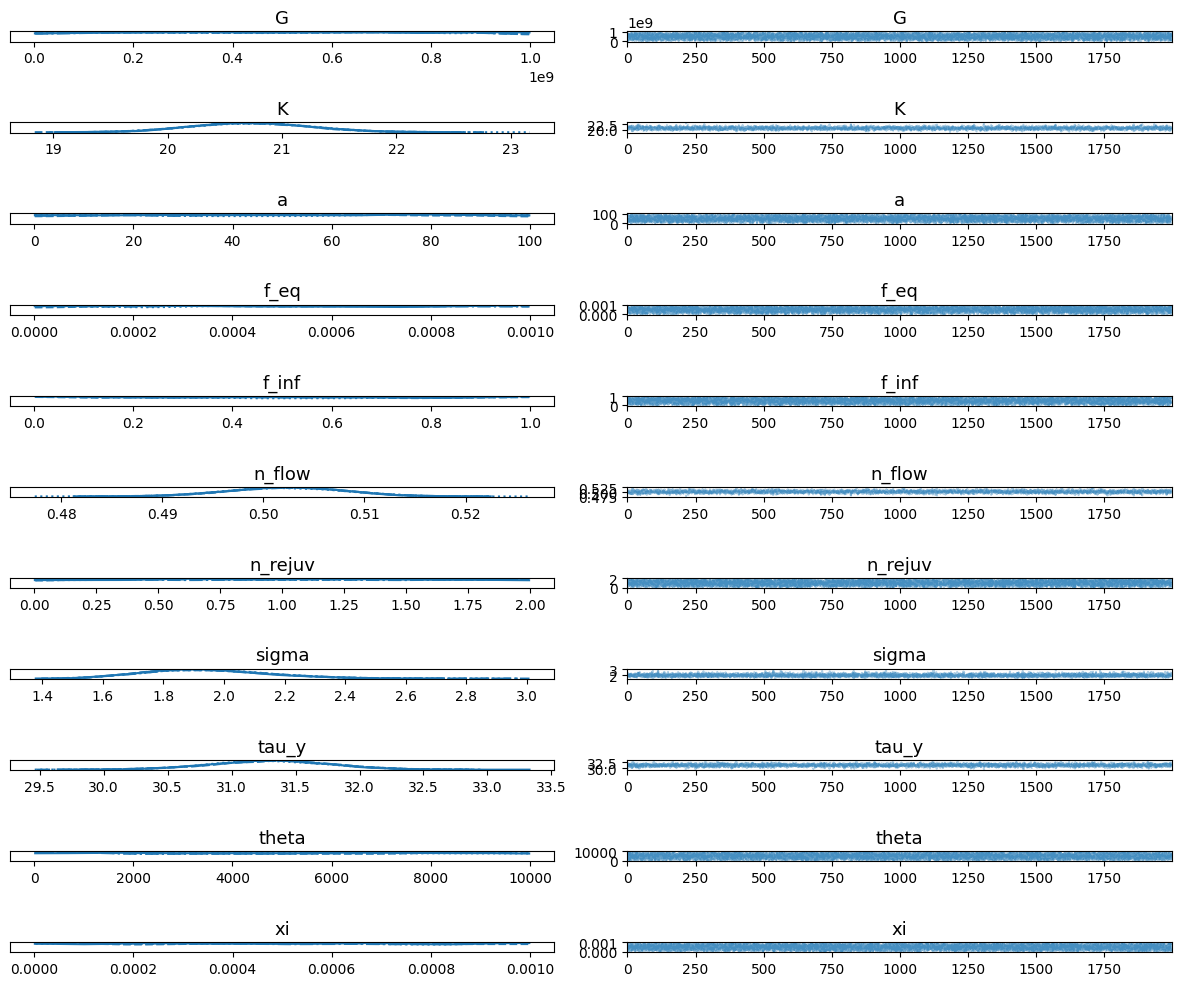

In [8]:
# Trace plots (check mixing)
az.plot_trace(idata, compact=True, figsize=(12, 10))
plt.tight_layout()
plt.show()

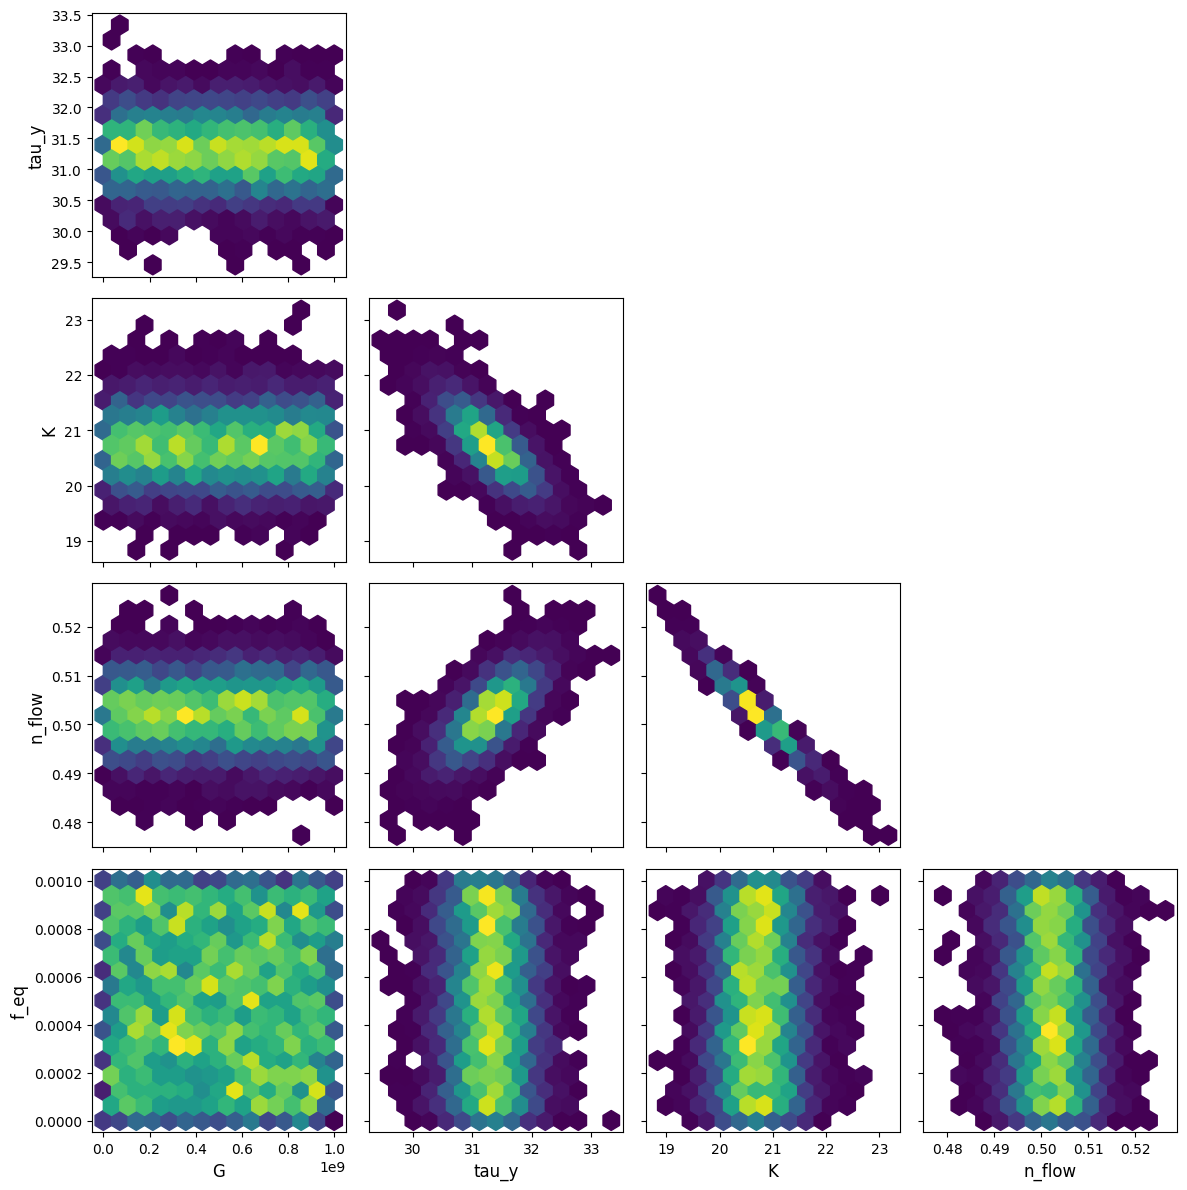

In [9]:
# Pair plot (correlations)
# Use actual parameter names from FluidityNonlocal model
param_names = list(model_nonlocal.parameters.keys())[:5]  # First 5 parameters

az.plot_pair(
    idata,
    var_names=param_names,
    kind='hexbin',
    divergences=True,
    figsize=(12, 12)
)
plt.tight_layout()
plt.show()
plt.close('all')

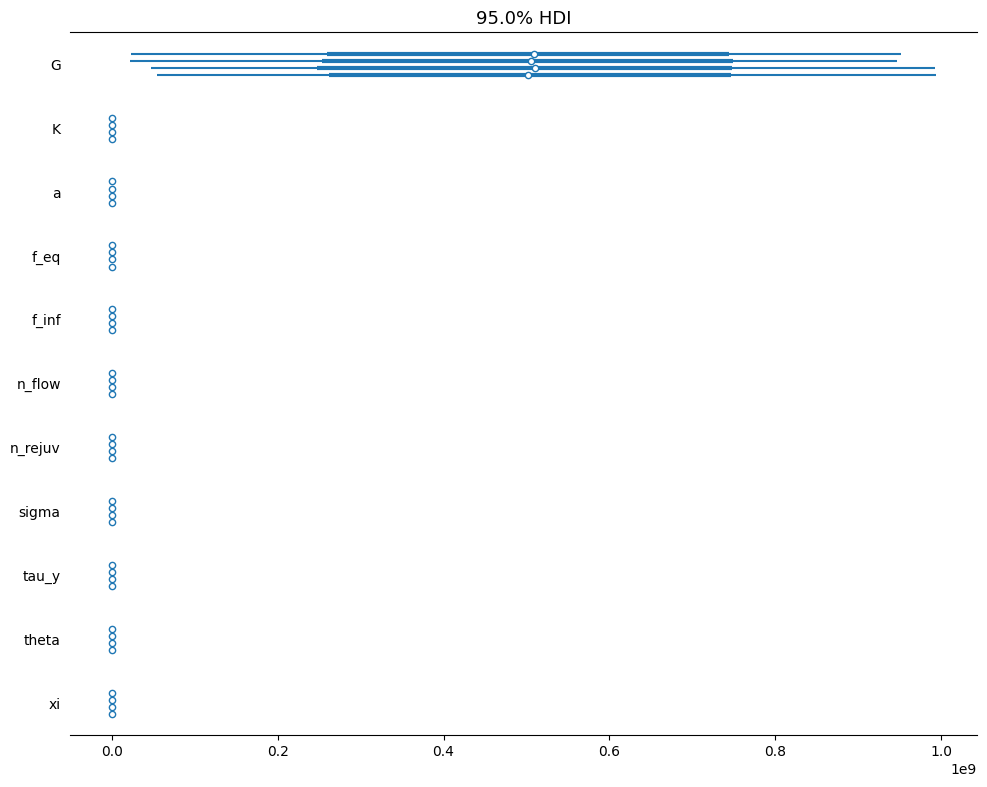

In [10]:
# Forest plot (credible intervals)
az.plot_forest(idata, hdi_prob=0.95, figsize=(10, 8))
plt.tight_layout()
plt.show()

## Comparison: Nonlocal vs Local Model

Fit **FluidityLocal** to assess whether non-local effects are necessary.

19:50:08 | INFO     | rheojax.models.fluidity.local | model_fit started | operation=model_fit | phase=start | model=FluidityLocal | test_mode=unknown | data_shape=(50,)


19:50:08 | INFO     | rheojax.utils.optimization | Using SciPy least_squares directly (method='scipy') | n_params=9


19:50:08 | INFO     | rheojax.models.fluidity.local | model_fit completed | operation=model_fit | phase=end | elapsed_seconds=0.1006 | status=success | model=FluidityLocal | test_mode=flow_curve | data_shape=(50,)


19:50:08 | INFO     | rheojax.core.base | Fit completed | model=FluidityLocal | fitted=True | R2=-4.7999e+04 | data_shape=(50,)



Local Model R² = -47999.335416
Nonlocal Model R² = -327.235013
Improvement: ΔR² = 47672.100403


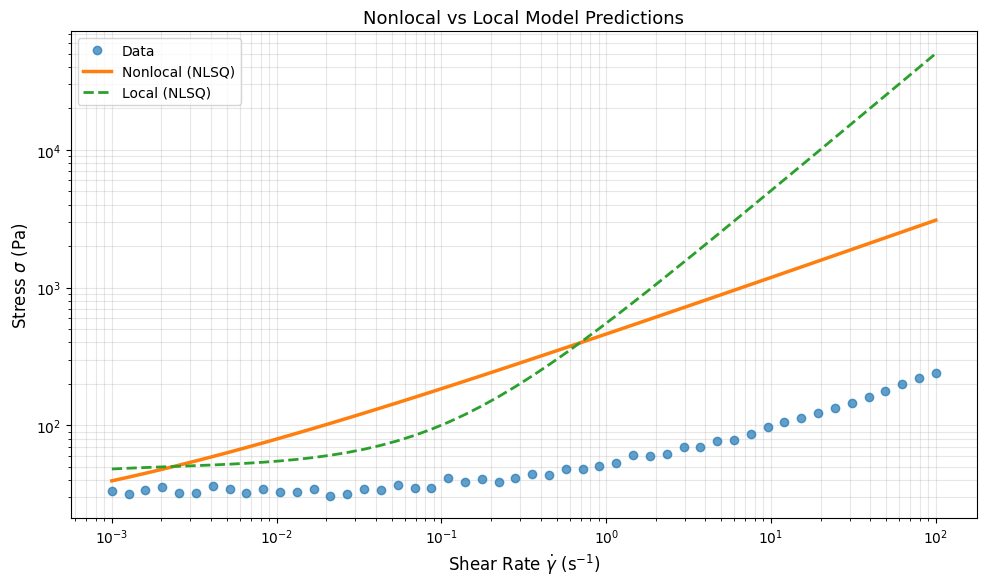

In [11]:
# Initialize local model (no spatial diffusion)
model_local = FluidityLocal()

# NLSQ fit
model_local.fit(gamma_dot, sigma, test_mode='flow_curve', method='scipy')

# Predictions
sigma_pred_local = model_local.predict(gamma_dot, test_mode='flow_curve')

# Compute fit quality
metrics_local = compute_fit_quality(sigma, np.array(sigma_pred_local).flatten())
r_squared_local = metrics_local['R2']

print(f"\nLocal Model R² = {r_squared_local:.6f}")
print(f"Nonlocal Model R² = {r_squared:.6f}")
print(f"Improvement: ΔR² = {r_squared - r_squared_local:.6f}")

# Overlay comparison
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, sigma, 'o', label='Data', alpha=0.7, markersize=6)
ax.loglog(gamma_dot, sigma_pred_nlsq, '-', label='Nonlocal (NLSQ)', linewidth=2.5)
ax.loglog(gamma_dot, sigma_pred_local, '--', label='Local (NLSQ)', linewidth=2)
ax.set_xlabel(r'Shear Rate $\dot{\gamma}$ (s$^{-1}$)')
ax.set_ylabel(r'Stress $\sigma$ (Pa)')
ax.set_title('Nonlocal vs Local Model Predictions')
ax.legend()
ax.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()
plt.close('all')

logger.info(
    "Model comparison complete",
    local_R2=r_squared_local,
    nonlocal_R2=r_squared
)

## Shear Banding Analysis

Compute fluidity profile statistics to detect shear banding.

In [12]:
# Extract cooperativity length from posterior
xi_samples = posterior['xi']
xi_median = float(jnp.median(xi_samples))
xi_hdi = intervals['xi']

print(f"\nCooperativity Length ξ:")
print(f"  Median: {xi_median*1e6:.2f} μm")
print(f"  95% HDI: [{xi_hdi[0]*1e6:.2f}, {xi_hdi[1]*1e6:.2f}] μm")
print(f"  Gap width: {model_nonlocal.gap_width*1e3:.2f} mm")
print(f"  Ratio ξ/h: {xi_median/model_nonlocal.gap_width:.4f}")

# Shear banding criterion
if xi_median / model_nonlocal.gap_width > 0.01:
    print("\n⚠ Non-local effects significant (ξ/h > 0.01) → potential shear banding")
else:
    print("\n✓ Local approximation valid (ξ/h < 0.01) → minimal shear banding")

# Note: Full fluidity profile f(y) would require spatial simulation
# For flow curve fitting, we use spatially-averaged response
# True banding detection requires startup/creep protocols with spatial resolution


Cooperativity Length ξ:


  Median: 499.70 μm
  95% HDI: [37.40, 988.37] μm
  Gap width: 1.00 mm
  Ratio ξ/h: 0.4997

⚠ Non-local effects significant (ξ/h > 0.01) → potential shear banding


## Save Results

Export NLSQ parameters, Bayesian posteriors, and diagnostics.

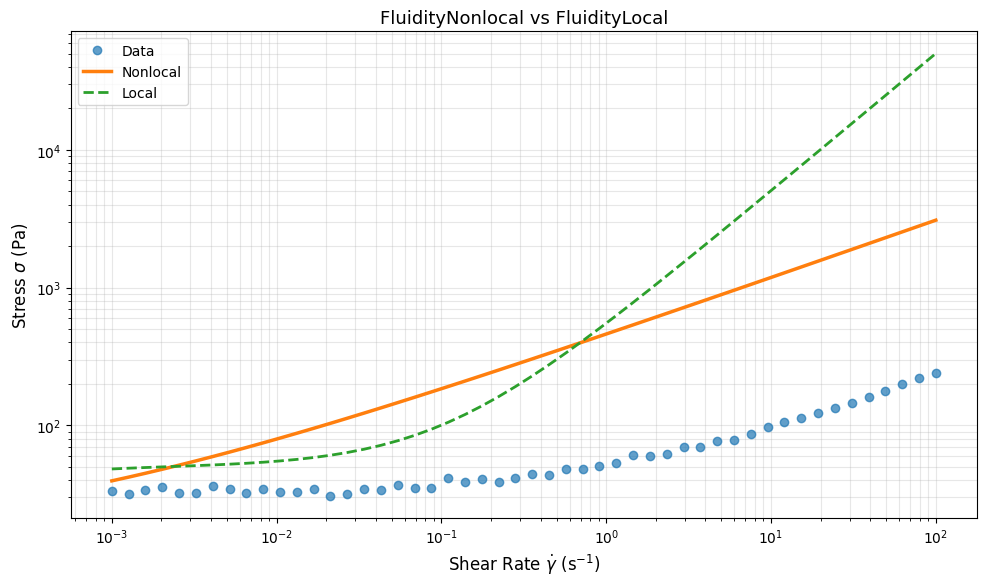


Results saved to: /Users/b80985/Projects/rheojax/examples/fluidity/../outputs/fluidity/nonlocal/flow_curve


In [13]:
# Create output directory
output_dir = Path('../outputs/fluidity/nonlocal/flow_curve')
output_dir.mkdir(parents=True, exist_ok=True)

# Save NLSQ parameters
params_file = output_dir / 'nlsq_parameters.txt'
with open(params_file, 'w') as f:
    f.write("NLSQ Fitted Parameters\n")
    f.write("=" * 40 + "\n\n")
    for name, value in params_nlsq.items():
        f.write(f"{name:12s}: {value:12.6e}\n")
    f.write(f"\nR² = {r_squared:.8f}\n")
    f.write(f"RMSE = {rmse:.6f} Pa\n")

# Save Bayesian summary
summary_file = output_dir / 'bayesian_summary.txt'
with open(summary_file, 'w') as f:
    f.write(summary.to_string())

# Save posterior samples (NetCDF format)
posterior_file = output_dir / 'posterior.nc'
idata.to_netcdf(posterior_file)

# Save comparison plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, sigma, 'o', label='Data', alpha=0.7, markersize=6)
ax.loglog(gamma_dot, sigma_pred_nlsq, '-', label='Nonlocal', linewidth=2.5)
ax.loglog(gamma_dot, sigma_pred_local, '--', label='Local', linewidth=2)
ax.set_xlabel(r'Shear Rate $\dot{\gamma}$ (s$^{-1}$)')
ax.set_ylabel(r'Stress $\sigma$ (Pa)')
ax.set_title('FluidityNonlocal vs FluidityLocal')
ax.legend()
ax.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.savefig(output_dir / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close('all')

print(f"\nResults saved to: {output_dir.absolute()}")
logger.info("Results saved", output_dir=str(output_dir.absolute()))

## Key Takeaways

### When Non-Local Effects Matter

1. **Cooperativity length ξ:**
   - $\xi/h < 0.01$: Local model sufficient (uniform fluidity)
   - $0.01 < \xi/h < 0.1$: Moderate non-local effects (weak banding)
   - $\xi/h > 0.1$: Strong non-local effects (pronounced shear banding)

2. **Protocol dependence:**
   - **Flow curves**: Steady-state averages $\implies$ local model often adequate
   - **Startup**: Transient banding $\implies$ nonlocal model critical
   - **Creep**: Viscosity bifurcation $\implies$ nonlocal reveals delayed yielding

3. **Material signatures:**
   - **Emulsions**: Moderate ξ (10-50 μm), weak-to-moderate banding
   - **Microgels**: Large ξ (50-200 μm), strong banding
   - **Colloidal glasses**: Small ξ (1-10 μm), nearly local behavior

4. **Computational cost:**
   - Local model: $O(N_{\dot{\gamma}})$ algebraic solve
   - Nonlocal model: $O(N_{\dot{\gamma}} \times N_y \times N_t)$ PDE solve
   - Use local model first; upgrade to nonlocal if $R^2$ improvement $> 0.05$

### Model Selection Workflow

```
1. Fit FluidityLocal → get R²_local
2. Fit FluidityNonlocal → get R²_nonlocal, ξ
3. If ΔR² > 0.05 AND ξ/h > 0.01:
     → Nonlocal effects significant, use FluidityNonlocal
   Else:
     → Local approximation valid, use FluidityLocal
```

### Next Steps

- **Startup simulations**: Reveal stress overshoot and band formation dynamics
- **Creep protocols**: Detect viscosity bifurcation (slow vs fast creep)
- **LAOS analysis**: Nonlinear stress-strain loops with spatial heterogeneity
- **Parameter identifiability**: Joint analysis of multiple protocols to constrain ξ